# CAMS Exploratory Analysis Demonstation

In [282]:
import iris
import iris.quickplot as qplt
from iris.time import PartialDateTime
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
import datetime
from matplotlib.ticker import MaxNLocator
import cf_units
import imageio
import glob
import nbs.external_py as ex

## Load Cube

The `iris` library holds NetCDF files in _cubes_. In this demo we will be using a NetCDF file from CAMS, a satellite reanalysis product that allows for measurements to be recorded anywhere across the earth's surface. 

In [227]:
cube = ex.iris_loader('data/europe_demo.nc')

### Lazy Data

The particular NetCDF file that we're working with here is quite small at just 180mb, however, many NetCDF files are much larger. In fact, the original, unconstrained CAMS reanalysis file was 9gb. To make the manipulation of such large files computationally possible, iris loads all data in lazilly, by default. The data will remain in a lazy state until it has been realised. 

We can check the status of the data through a simple one-line command.

In [228]:
cube.has_lazy_data()

True

#### Realising the Data 

Once the data is realised, it must be loaded into RAM and therefore no longer in a lazy state. That does not make it impossible to work with however, as the data is not loaded in full to memory, instead it is done in chunks.

In [229]:
cube.data.shape
cube.has_lazy_data()

False

## Filtering UK
The dataset is currently quite large as it covers the entirity of Europe. To try and ease the computational burden we will restrict the data to only the UK. 

To filter in `iris` we must instantiate a `Constraint` object for which the cube's dimensions can be collapsed upon. Here we'll be using rough reference points for the UK and Ireland spatially constrain our cube. 

In [230]:
uk_constraint = iris.Constraint(coord_values={'latitude':lambda cell: 49.7 < cell < 61, 
                                             'longitude': lambda cell: -10.651 < cell < 1.87})
cube_uk = cube.extract(uk_constraint)

We can assess if our constraint has worked by inspecting the cube's shape before and after the constraint is applied.

In [231]:
print('Full shape: {}'.format(cube.shape))
print('UK shape: {}'.format(cube_uk.shape))

Full shape: (168, 401, 701)
UK shape: (168, 112, 125)


## Plot on Map

Iris allows for NetCDF files to easilly be visualised, however, only for a single point in time. To do this we must define a new constraint using Iris' `PartialDateTime` object.

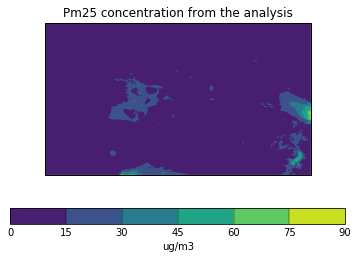

In [232]:
llim = iris.time.PartialDateTime(2014, 6, 1, 1)
ulim = iris.time.PartialDateTime(2014, 6, 1, 2)
year_constraint = iris.Constraint(coord_values={'time':lambda cell: llim <= cell < ulim})

first = cube.extract(year_constraint)

qplt.contourf(first);

### More Detailed Plots

Iris' plotting capabilities entirely upon matplotlib, meaning that we are able to layer our plots, alter the colour schemes and annotate freely. Iris does feature maps by default, however, these are coarse and unsatisfactory if more detail is required. To avoid this issue, we can define our own map and the map's resolution.

In [247]:
uk_map = Basemap(projection='merc', lat_0 =  53.866772, lon_0 = -5.23636,resolution = 'i', area_thresh = 0.05,
              llcrnrlon=-10.65073, llcrnrlat=49.85,urcrnrlon=1.76334, urcrnrlat=60.8)

def cube_plot(cube, basemap, lims=(0, 50)):
    # Get the cube's timestamp
    full_timestamp = cube.coord('time').units.num2date(cube.coord('time').points[0])
    timestamp = str(full_timestamp).replace(' ', '__').replace('-', '_')[:-6]
    
    # coerce data
    y = cube.coord('latitude').points
    x = cube.coord('longitude').points
    data = cube.data.data
    x, y = np.meshgrid(x,y)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 20));
    levels = MaxNLocator(nbins=250).tick_values(lims[0], lims[1])
    pms = basemap.contourf(x, y, data, latlon=True, cmap='hot_r', levels=levels);
    
    # Overlay coastlines
    basemap.drawcoastlines(linewidth = 0.5);
    
    # Add extras
    cbar = fig.colorbar(pms, orientation='horizontal', pad=0.02);
    cbar.set_label('ug/m3 PM2.5 level');
    cbar.set_clim(lims[0], lims[1])
    plt.title('PM2.5 Levels: {}'.format(full_timestamp));
    plt.tight_layout()
    plt.savefig('heatmaps/maximum_pm_{}.png'.format(timestamp));

We are now in a position to plot any cube, provided it 2-dimensional and a set of value limits are supplied.

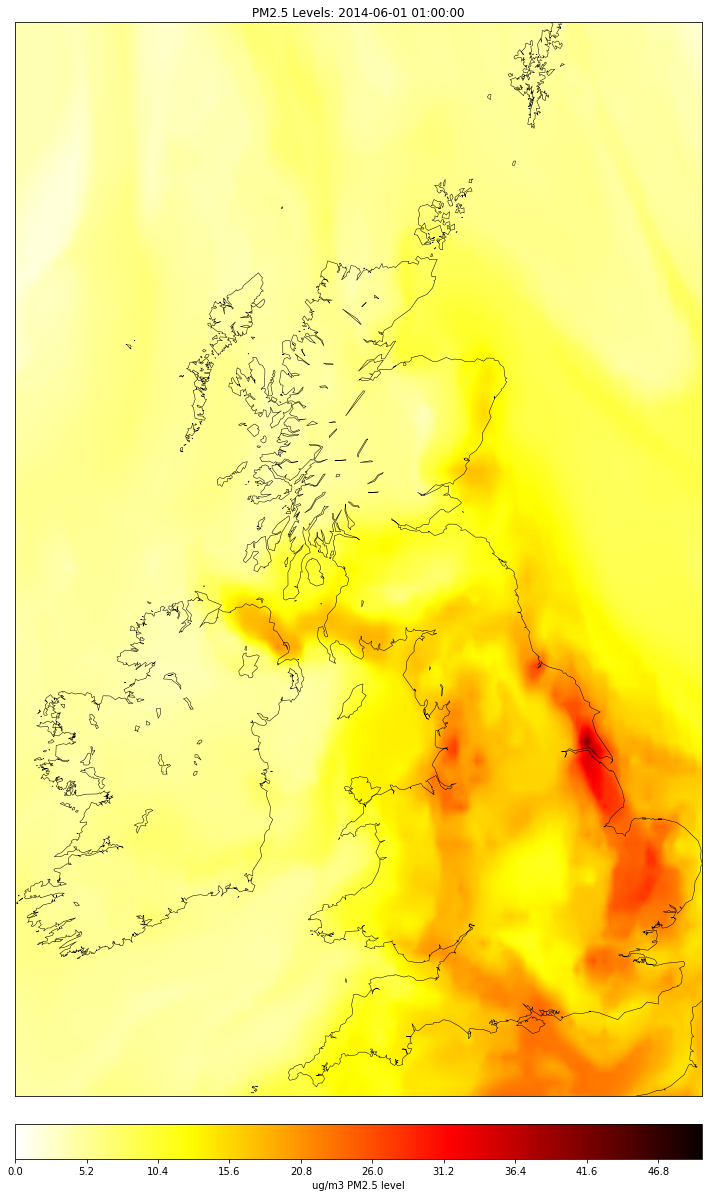

In [248]:
cube_plot(first, uk_map, (0, 50))

### Animate Plots

Using imageio, we can also animate these plots. The `%%capture` magic command here prevents Jupyter from printing out each and every image produced, meaning the process is somewhat faster and the notebook does not become cluttered with several incrementally changing maps.

In [249]:
%%capture
j = 0
llim = 0
ulim = 55
cube_lim = 72
hour_break = 2

for i in cube_uk.slices(['latitude', 'longitude']):
    if j > cube_lim:
        break
    if j%hour_break==0:
        cube_plot(i, uk_map, lims=(llim, ulim))
    j += 1 


### Collating Images into a GIF

With images produced, we can now collated into a .gif file.

In [250]:
filenames = glob.glob('heatmaps/*.png')

with imageio.get_writer('heatmaps/pm_cycle.gif', mode='I', duration=0.4) as writer:
    for filename in sorted(filenames):
        image = imageio.imread(filename)
        writer.append_data(image)

### View

Using the `%system` magic command, we can now view our newly created .gif.

In [252]:
%system xdg-open heatmaps/pm_cycle.gif

[]

# Extracting Our Desired Slice

Later on we're going to fuse together point level location data with the satellite data seen above. The point data we have is currently on a daily means resolution. To get the satellite data onto the same resolution we need to _collapse_ a day into the day's mean. Fortunately, in iris this is quite simple as we can just collapse upon a single dimension.

In [255]:
def constrain(cube, lower, upper):
    low_date = iris.time.PartialDateTime(lower.year, lower.month, lower.day, 0)
    high_date = iris.time.PartialDateTime(upper.year, upper.month, upper.day, 0)
    constraint = iris.Constraint(coord_values={'time': lambda cell: low_date <= cell < high_date})
    constrained = cube.extract(constraint)
    return constrained


lower = datetime.datetime(year = 2014, month = 6, day = 1)
upper = datetime.datetime(year = 2014, month = 6, day = 2)

apr_first = constrain(cube_uk, lower, upper)


### Collapse

With the desired day subsetted from the cube, we can now collapse upon the time coordinate, averaging the values as we do.

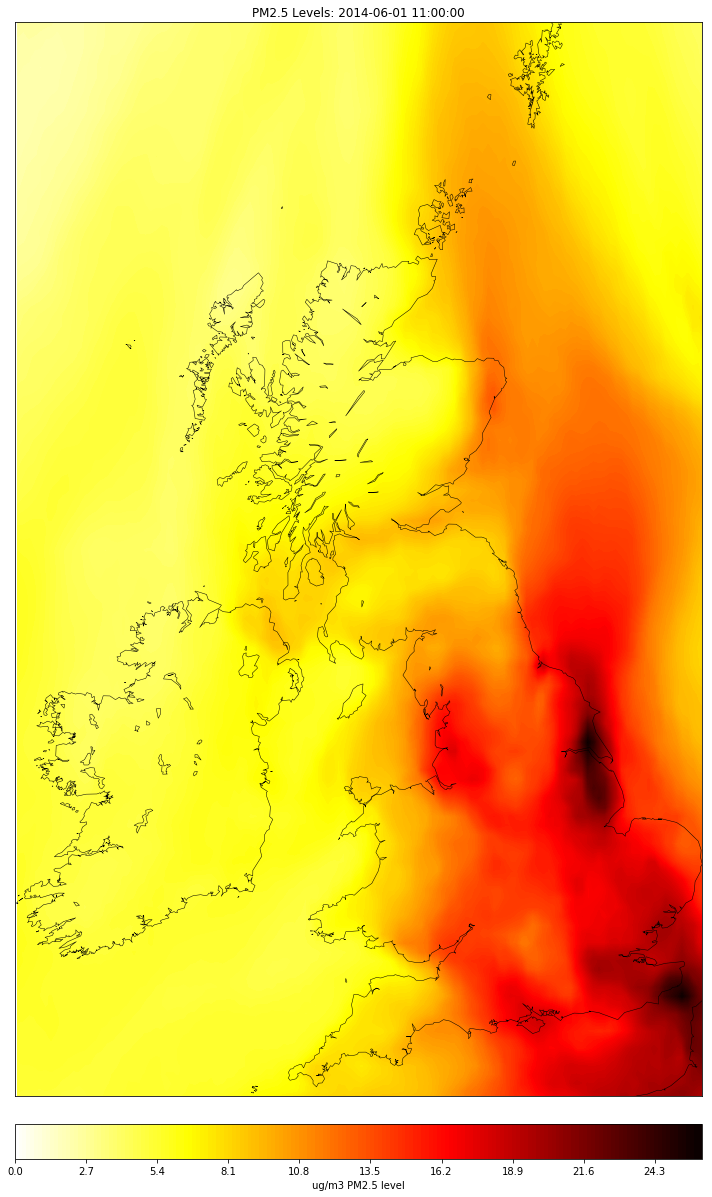

In [259]:
mean_vals = apr_first.collapsed('time', iris.analysis.MEAN)
cube_plot(mean_vals, uk_map, (0, np.amax(mean_vals.data)))

### Store

With our NetCDF file produced, we can now store it for later use in our modelling in R.

In [260]:
iris.save(mean_vals, 'data/hourly_slice.nc')

# Fuse Monitoring Stations and Satellite Data

The CAMS data is great, however, we also have some on-the-ground monitoring station data available for us to use. If it was possible to _fuse_ together the two datasets, then we will potentially be able to move our model closer to the true $PM_{2.5}$ level.

As a first approach to this, we'll fit a Gaussian process to the points whereby a monitoring station exists, with our response $Y$ being the AURN monitoring station's measurement and spatially referenced predictors $X$ being the CAMS reanalysis estimate. We can therefore write out model as $$Y(s)=X^T(s)+w(s)+\epsilon(s),$$ where $w(s)\sim NNGP(0, C(s, s'))$. A nearest neighbour Gaussian process (NNGP) works very similarly to a standard GP, however, to ease the processes' computational burder, we conditon upon a set of $m$ neighbouring spatial locations. By doing this, each row of the precision matrix then contains $m$ entries, where $m<<n$, making it incredidbly sparse and following matrix inversion much faster.

In [275]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [276]:
%%R
library(tidyverse)
library(spNNGP)
library(knitr)
library(ggplot2)
library(RColorBrewer)
library(raster)
library(sp)
library(rgeos)
library(rasterVis)
library(geosphere)
set.seed(123)
slice_ref <- "2014-06-01"
point_size <- 3

## Load AURN Monitoring Data

Lets first load the data and take a look at the content of the dataset. We're using the AURN monitoring station daily means dataset. Initially this will be modelled for a fixed point in time, namely `r slice_ref`. Over time this will be extended out to incorporate a temporal dimension.

In [277]:
%%R
aurn <- read_csv('data/aurn_joined.csv')

slice <- aurn %>% 
  dplyr::filter(Date == slice_ref)

## Visualise

After filtering out AQ values recorded on days other than 2014-06-01 we are left with a dataset containing a subset of the original set observations which we can view on a map. We can assess the dispersion of the AURN monitoring sites by plotting them over a map of the UK. The colour of each point is indicative of the level of $\text{PM}_{2.5}$ at the monitoring site on 2014-06-01.

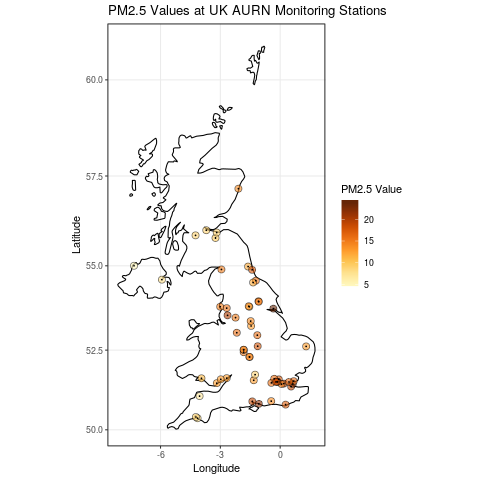

In [278]:
%%R
UK <- map_data(map = "world", region = "UK") # changed map to "world"

cols <- brewer.pal(n = 9, name =  'YlOrBr')[2:9]

ggplot(data = UK, aes(x = long, y = lat, group = group)) + 
  geom_path() +
  geom_point(data = slice, aes(x = Longitude, y = Latitude, group = 1, fill = pm25_value), size = point_size, alpha = 0.6, pch = 21, colour = 'black') +
  geom_point(data = slice, aes(x = Longitude, y = Latitude, group = 1), size = 0.2) +
  scale_fill_gradientn(colours = cols) +
  coord_map() +
  labs(x = 'Longitude', y = 'Latitude', title = 'PM2.5 Values at UK AURN Monitoring Stations', fill = 'PM2.5 Value') +
  theme_bw()

## NetCDF Data

As can be seen above, the monitoring stations are quite sparse. In order to _fill in gaps_, we can leverage CAMS monitoring data which will cover the entire UK. Unfortunately, the response of the CAMS model is not perfect, moreover a data assimilation reanalysis that gives a best guess of air quality levels on a given date. 

Fortunately, we already have a clean and formatted NetCDF file from our previous analysis that we can now use.

In [268]:
%%R
cams_nc <- brick('data/hourly_slice.nc')

nc_to_df <- function(cube){
  s <- as.data.frame(cube[[1]], xy = TRUE)
  print(paste(dim(s)[1], ' values stored.', sep = ''))
  return(s)
}

cams <- nc_to_df(cams_nc)

[1] "14000 values stored."


# Get AURN Nearest Neighbour

To find the closest CAMS measurement to each AURN monitoring station, we must first find the closest CAMS measurement for every AURN station. To do this, we'll use the CAMS measurement with the smallest Euclidean distance to each AURN station.


In [269]:
%%R
aurn_coord <- SpatialPoints(cbind(slice$Longitude, slice$Latitude))
cams_coord <- SpatialPoints(cbind(cams$x, cams$y))

# Get neighbour distance in metres
neighbours <- as.data.frame(dist2Line(aurn_coord, cams_coord))
colnames(neighbours) <- c('distance', 'n_lon', 'n_lat')

slice_n <- cbind(slice, neighbours)

slice_full <- slice_n %>% 
  mutate(lat_r = round(n_lat, 1),
         lon_r = round(n_lon, 1)) 

cams_r <- cams %>% 
  mutate(x = round(x, 1), 
         y = round(y, 1))

all_data <- left_join(slice_full, cams_r, by = c("lat_r" = "y", "lon_r" = "x"))

x <- sample(1:dim(all_data)[1], size = dim(all_data)[1]-10)
all_train <- all_data[x, ]
all_test <- all_data[-x, ]

# Build a Model

Now that we have data for AURN monitoring stations and each station's closest CAMS prediction we can begin to construct our model. We'll place priors over 

In [270]:
%%R
rmvn <- function(n, mu=0, V = matrix(1)){
  p <- length(mu)
  if(any(is.na(match(dim(V), p))))
  stop("Dimension problem!")
  D <- chol(V)
  t(matrix(rnorm(n*p), ncol = p)%*%D + rep(mu,rep(n,p)))
}

n <- length(all_train$pm25_value)
x <- cbind(1, all_train$layer)
coords <- cbind(all_train$Latitude, all_train$Longitude)

B <- as.matrix(c(1,5))

sigma.sq <- 5
tau.sq <- 1
phi <- 3/0.5

D <- as.matrix(dist(coords))
R <- exp(-phi*D)
w <- rmvn(1, rep(0, n), sigma.sq*R)
y <- all_train$pm25_value

n.samples <- 500
starting <- list("phi" = phi, "sigma.sq" = 5, "tau.sq" = 1)
tuning <- list("phi" = 0.5, "sigma.sq" = 0.5, "tau.sq" = 0.5)
priors <- list("phi.Unif" = c(3/1, 3/0.01), "sigma.sq.IG" = c(2, 5), "tau.sq.IG" = c(2, 1))
cov.model <- "exponential"



m.r <- spNNGP(y~x-1, coords = coords, starting = starting, method = "response", n.neighbors = 10,
              tuning = tuning, priors = priors, cov.model = cov.model, n.samples = n.samples, n.omp.threads = 4, verbose = FALSE)

## Make Predictions at New Locations

In [271]:
%%R
all_to_join <- all_train %>% 
  dplyr::select(c(lat_r, lon_r, layer))
colnames(all_to_join) <- c('y', 'x', 'layer')

hold_out <- rbind(cams_r, all_to_join)

preds <- spNNGP::spPredict(m.r, X.0 = cbind(1, hold_out$layer), coords.0 = cbind(hold_out$y, hold_out$x), n.omp.threads = 4, verbose = FALSE)

mean_preds <- rowMeans(preds$p.y.0)
hold_out$gp_preds <- mean_preds

## Visualise Predictions 

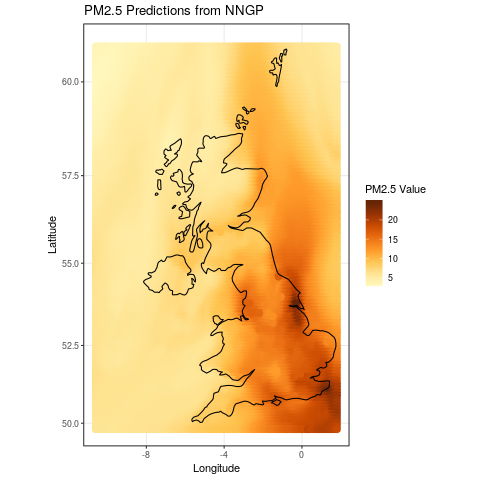

In [272]:
%%R
ggplot(data = UK, aes(x = long, y = lat, group = group)) + 
  geom_point(data = hold_out, aes(x = x, y = y, group = 1, colour = gp_preds), size = point_size) +
  geom_path() +
  scale_colour_gradientn(colours = cols) +
  coord_map() +
  labs(x = 'Longitude', y = 'Latitude', title = 'PM2.5 Predictions from NNGP', colour = 'PM2.5 Value') +
  theme_bw()


## Inspect the Difference Between CAMS and NNGP

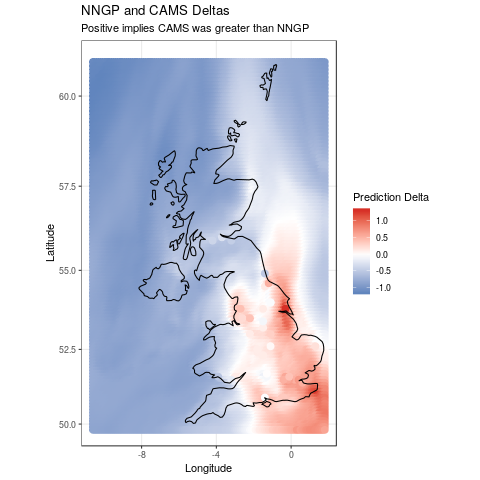

In [279]:
%%R
hold_out$pm_diff <- hold_out$layer - hold_out$gp_preds

diff_cols <- rev(brewer.pal(n = 9, name = 'RdYlBu'))

ggplot(data = UK, aes(x = long, y = lat, group = group)) + 
  geom_point(data = hold_out, aes(x = x, y = y, group = 1, colour = pm_diff), size = point_size) +
  geom_path() +
  scale_colour_gradient2(low = diff_cols[1], mid = 'white', high = diff_cols[9]) +
  coord_map() +
  labs(x = 'Longitude', y = 'Latitude', title = 'NNGP and CAMS Deltas', subtitle = 'Positive implies CAMS was greater than NNGP', colour = 'Prediction Delta') +
  theme_bw()

## Assess Posterior Uncertainties

Currently inspecting the posterior variances. At some point look into a possible better way of doing this.

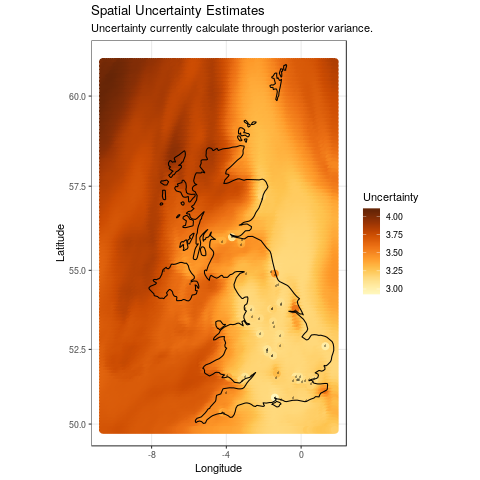

In [280]:
%%R

rowVar <- function(x, ...) {
  rowSums((x - rowMeans(x, ...))^2, ...)/(dim(x)[2] - 1)
}

var_preds <- rowVar(preds$p.y.0)
hold_out$uncertainty <- var_preds

ggplot(data = UK, aes(x = long, y = lat, group = group)) + 
  geom_point(data = hold_out, aes(x = x, y = y, group = 1, colour = uncertainty), size = point_size) +
  geom_point(data = slice, aes(x = Longitude, y = Latitude, group = 1), fill = 'green', shape = "d", size = 0.8, pch = 21, colour = 'black') +
  geom_path() +
  scale_colour_gradientn(colours = cols) +
  coord_map() +
  labs(x = 'Longitude', y = 'Latitude', title = 'Spatial Uncertainty Estimates', subtitle = 'Uncertainty currently calculate through posterior variance.', colour = 'Uncertainty') +
  theme_bw()